In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras.datasets import boston_housing
from sklearn import preprocessing as p

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 10)
matplotlib.rcParams['ytick.major.pad']='1'
plt.rcParams["axes.labelsize"] = 15

In [3]:
pd.set_option('display.width', 2000)
pd.set_option('precision', 3)
np.set_printoptions(precision=3, suppress=True)

## The Dataset
Boston Housing prices, columns are as follows:

    CRIM - per capita crime rate by town
    ZN -proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per 10,000
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT - Percent lower status of the population
    MEDV - Median value of owner-occupied homes in 1000's

In [4]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [5]:
x_headers = ["CRIM", "ZN","INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
y_headers = ["MEDV"]

In [7]:
trainDF = pd.DataFrame(x_train, columns=x_headers)
trainDF['MEDV'] = y_train
trainDF.head()

CRIM    ZN  INDUS  CHAS    NOX     RM    AGE    DIS   RAD    TAX  PTRATIO       B  LSTAT  MEDV
0  1.232   0.0   8.14   0.0  0.538  6.142   91.7  3.977   4.0  307.0     21.0  396.90  18.72  15.2
1  0.022  82.5   2.03   0.0  0.415  7.610   15.7  6.270   2.0  348.0     14.7  395.38   3.11  42.3
2  4.898   0.0  18.10   0.0  0.631  4.970  100.0  1.333  24.0  666.0     20.2  375.52   3.26  50.0
3  0.040   0.0   5.19   0.0  0.515  6.037   34.5  5.985   5.0  224.0     20.2  396.90   8.01  21.1
4  3.693   0.0  18.10   0.0  0.713  6.376   88.4  2.567  24.0  666.0     20.2  391.43  14.65  17.7

## Observations
 - Aside from the 'CHAS' column, which is a discreet variable, the dataset has just continuous variables.

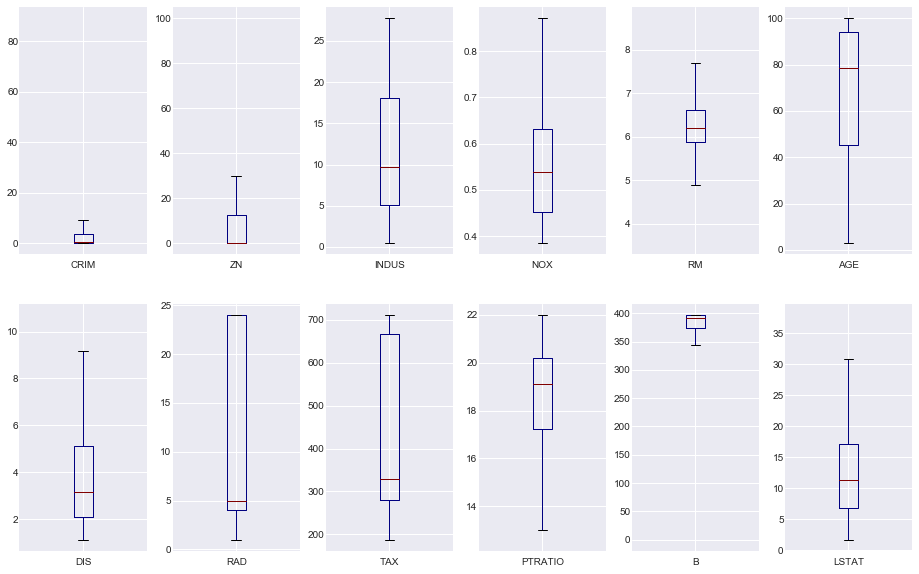

In [15]:
fig, axes= plt.subplots(2, 6)
_ = pd.DataFrame(x_train, columns=x_headers).drop('CHAS',1).plot(kind='box',subplots=True, ax=axes, colormap='jet')

## Observations
- Per Capita Crime, proportion of residential land zoned for lots over 25,000 sq.ft., and portion of blacks per town has several outliers outside the bounds of the interquartile range 
- The range across each feature is very different, and the spread varies significantly

## Preprocessing Techniques
Many machine learning models work best under the assumption that all the features of the input are near zero and have comparable scales. The reason why is that features with variances much larger than others will dominate the objective function and the predictive model would not learn as much from the other features. Because of this, it's a good idea to translate the dataset so it is centered around zero and scale each feature to have a unit standard deviation. 

It's worth noting that some models, like Decision Tree algorithms are robust to different scales.

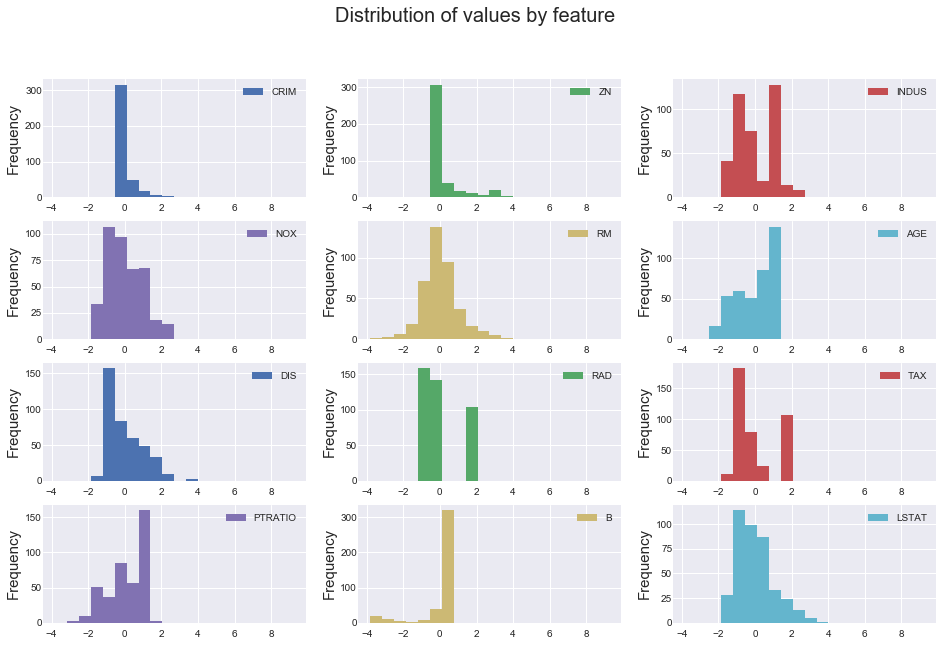

In [16]:
fig, axes= plt.subplots(4, 3)
_ = pd.DataFrame(p.scale(x_train), columns=x_headers).drop('CHAS',1).plot(kind='hist',bins=20,
                                             subplots=True, ax=axes)

_ = fig.suptitle("Distribution of values by feature",fontsize=20)

### Are there missing values?

In [46]:
empty_count = trainDF.isnull().sum()
total_count = trainDF.count()

print('Percent Missing by feature')
(empty_count//total_count).sort_values(ascending=True)

Percent Missing by feature


CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Are any two features highly correlated?

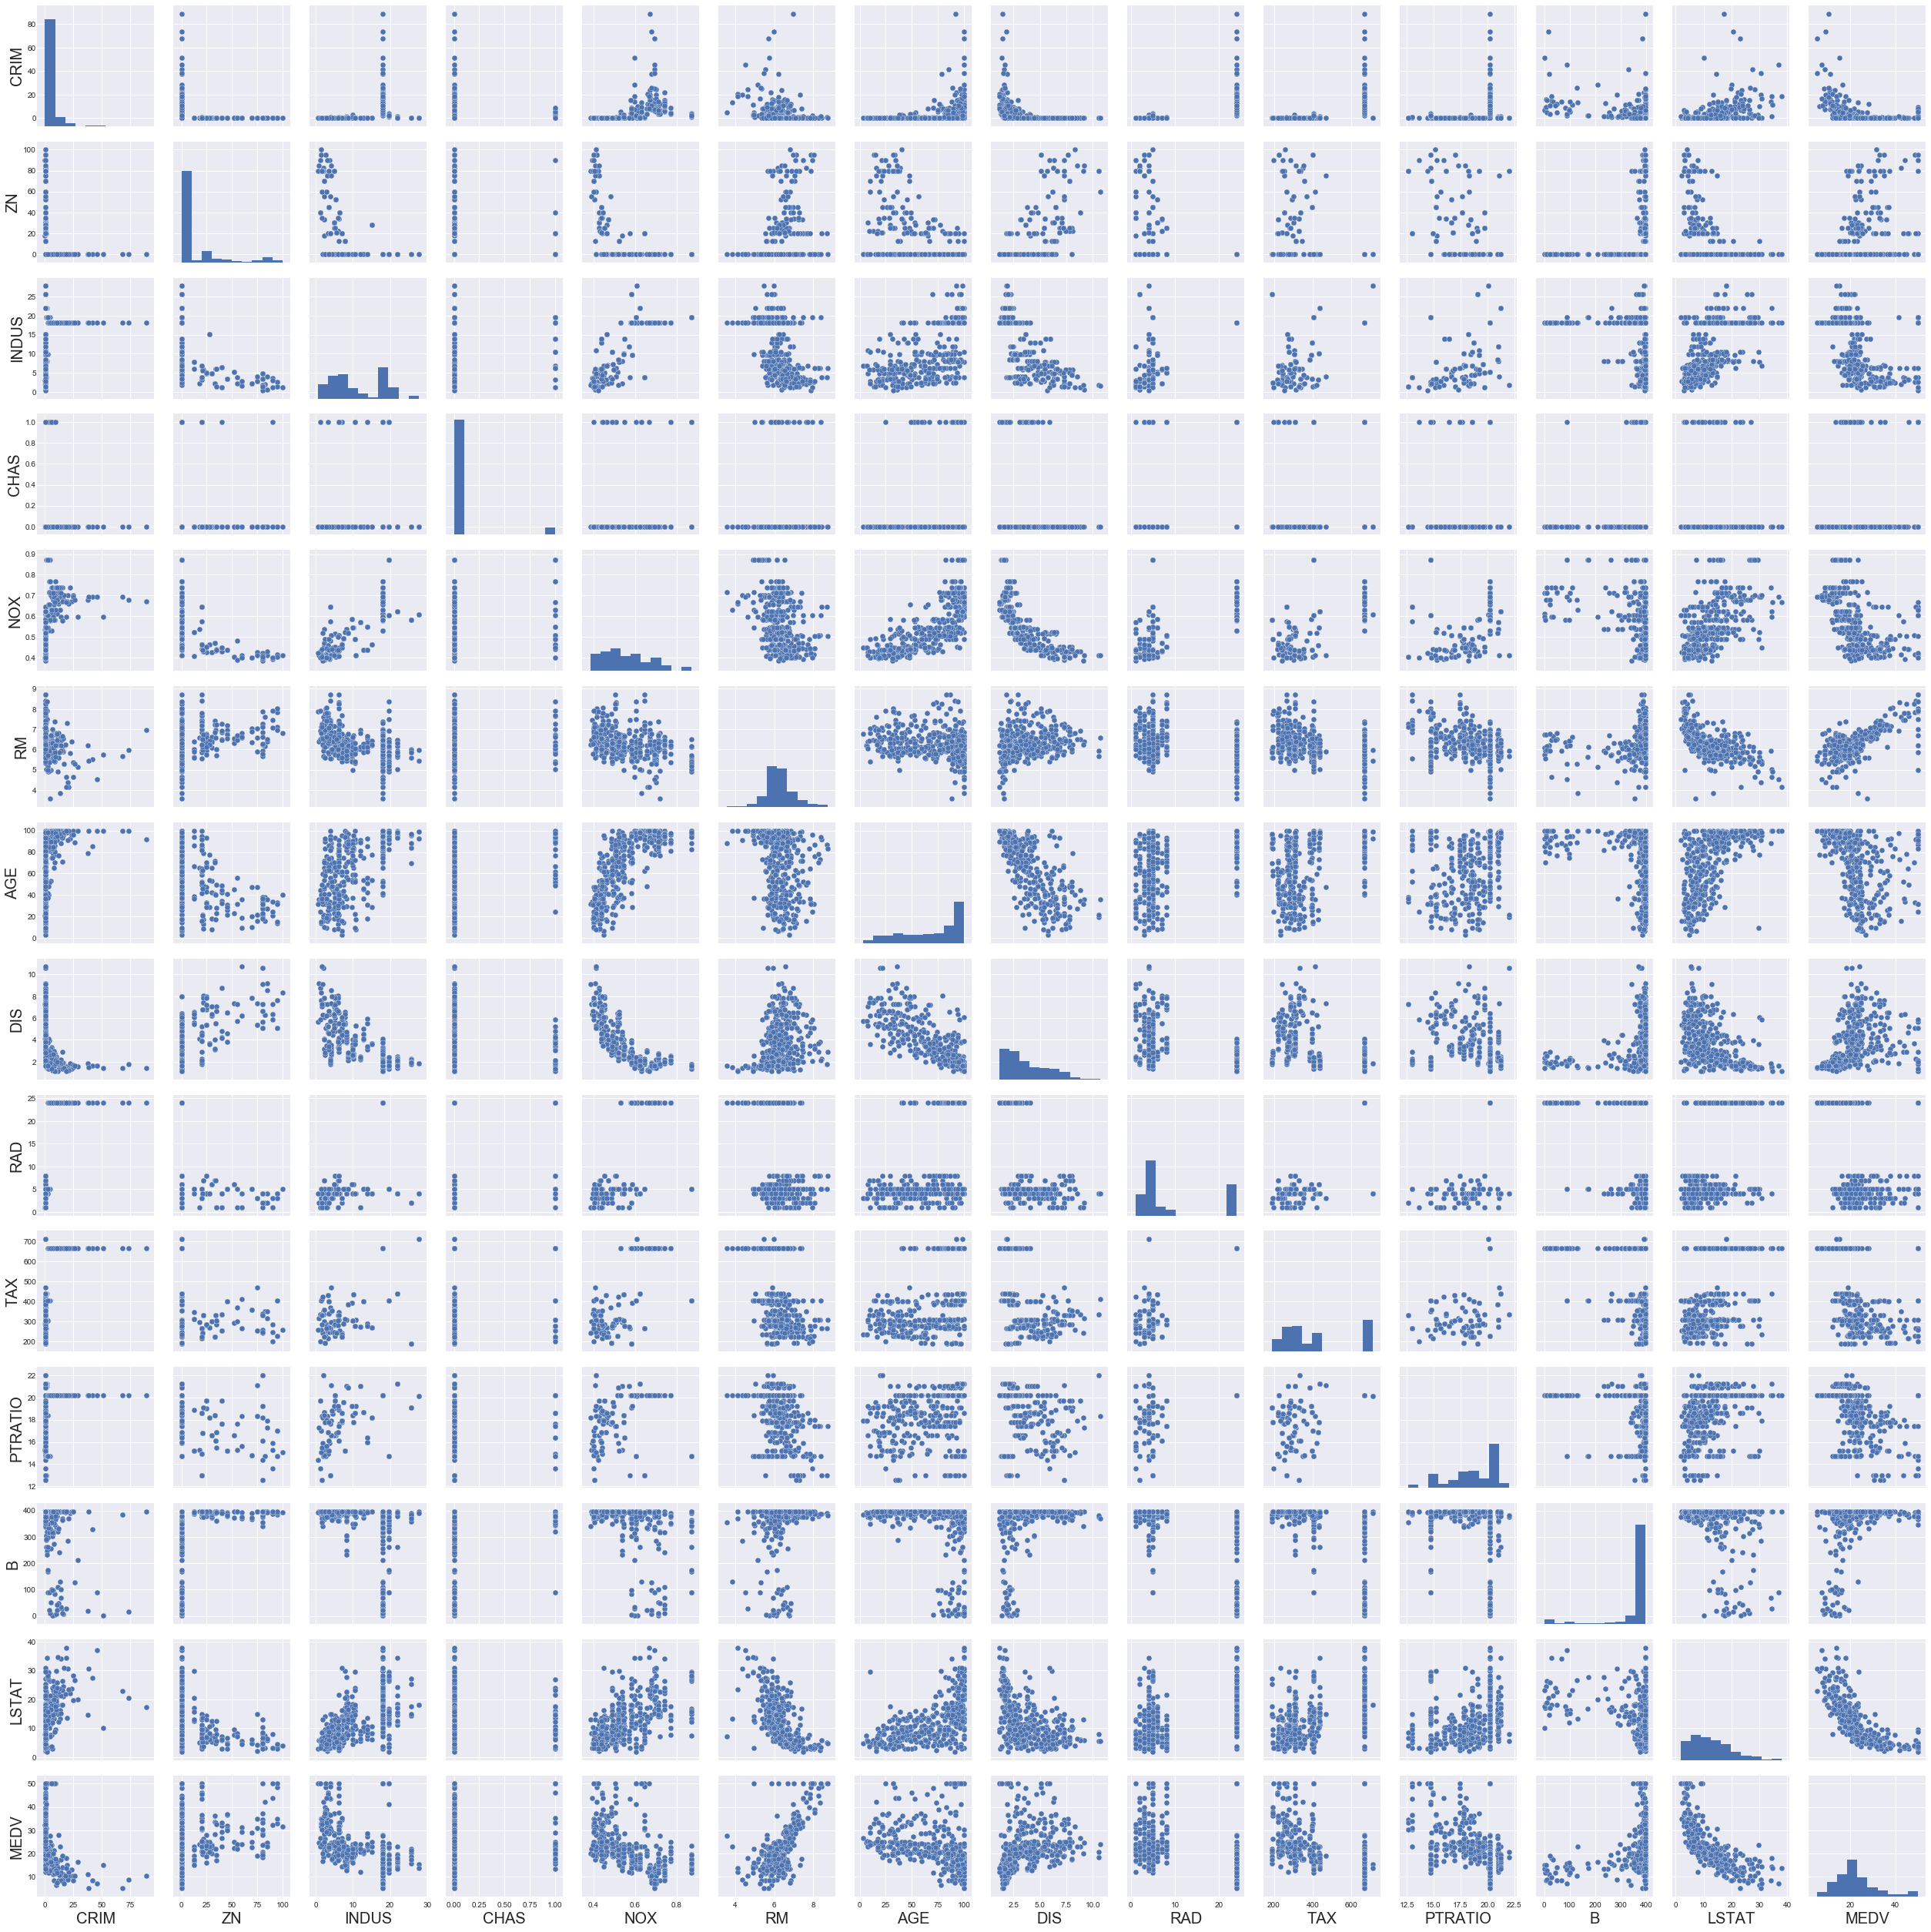

In [48]:
plt.rcParams["axes.labelsize"] = 20
_ = sns.pairplot(
    data = trainDF,
    vars=trainDF.columns)

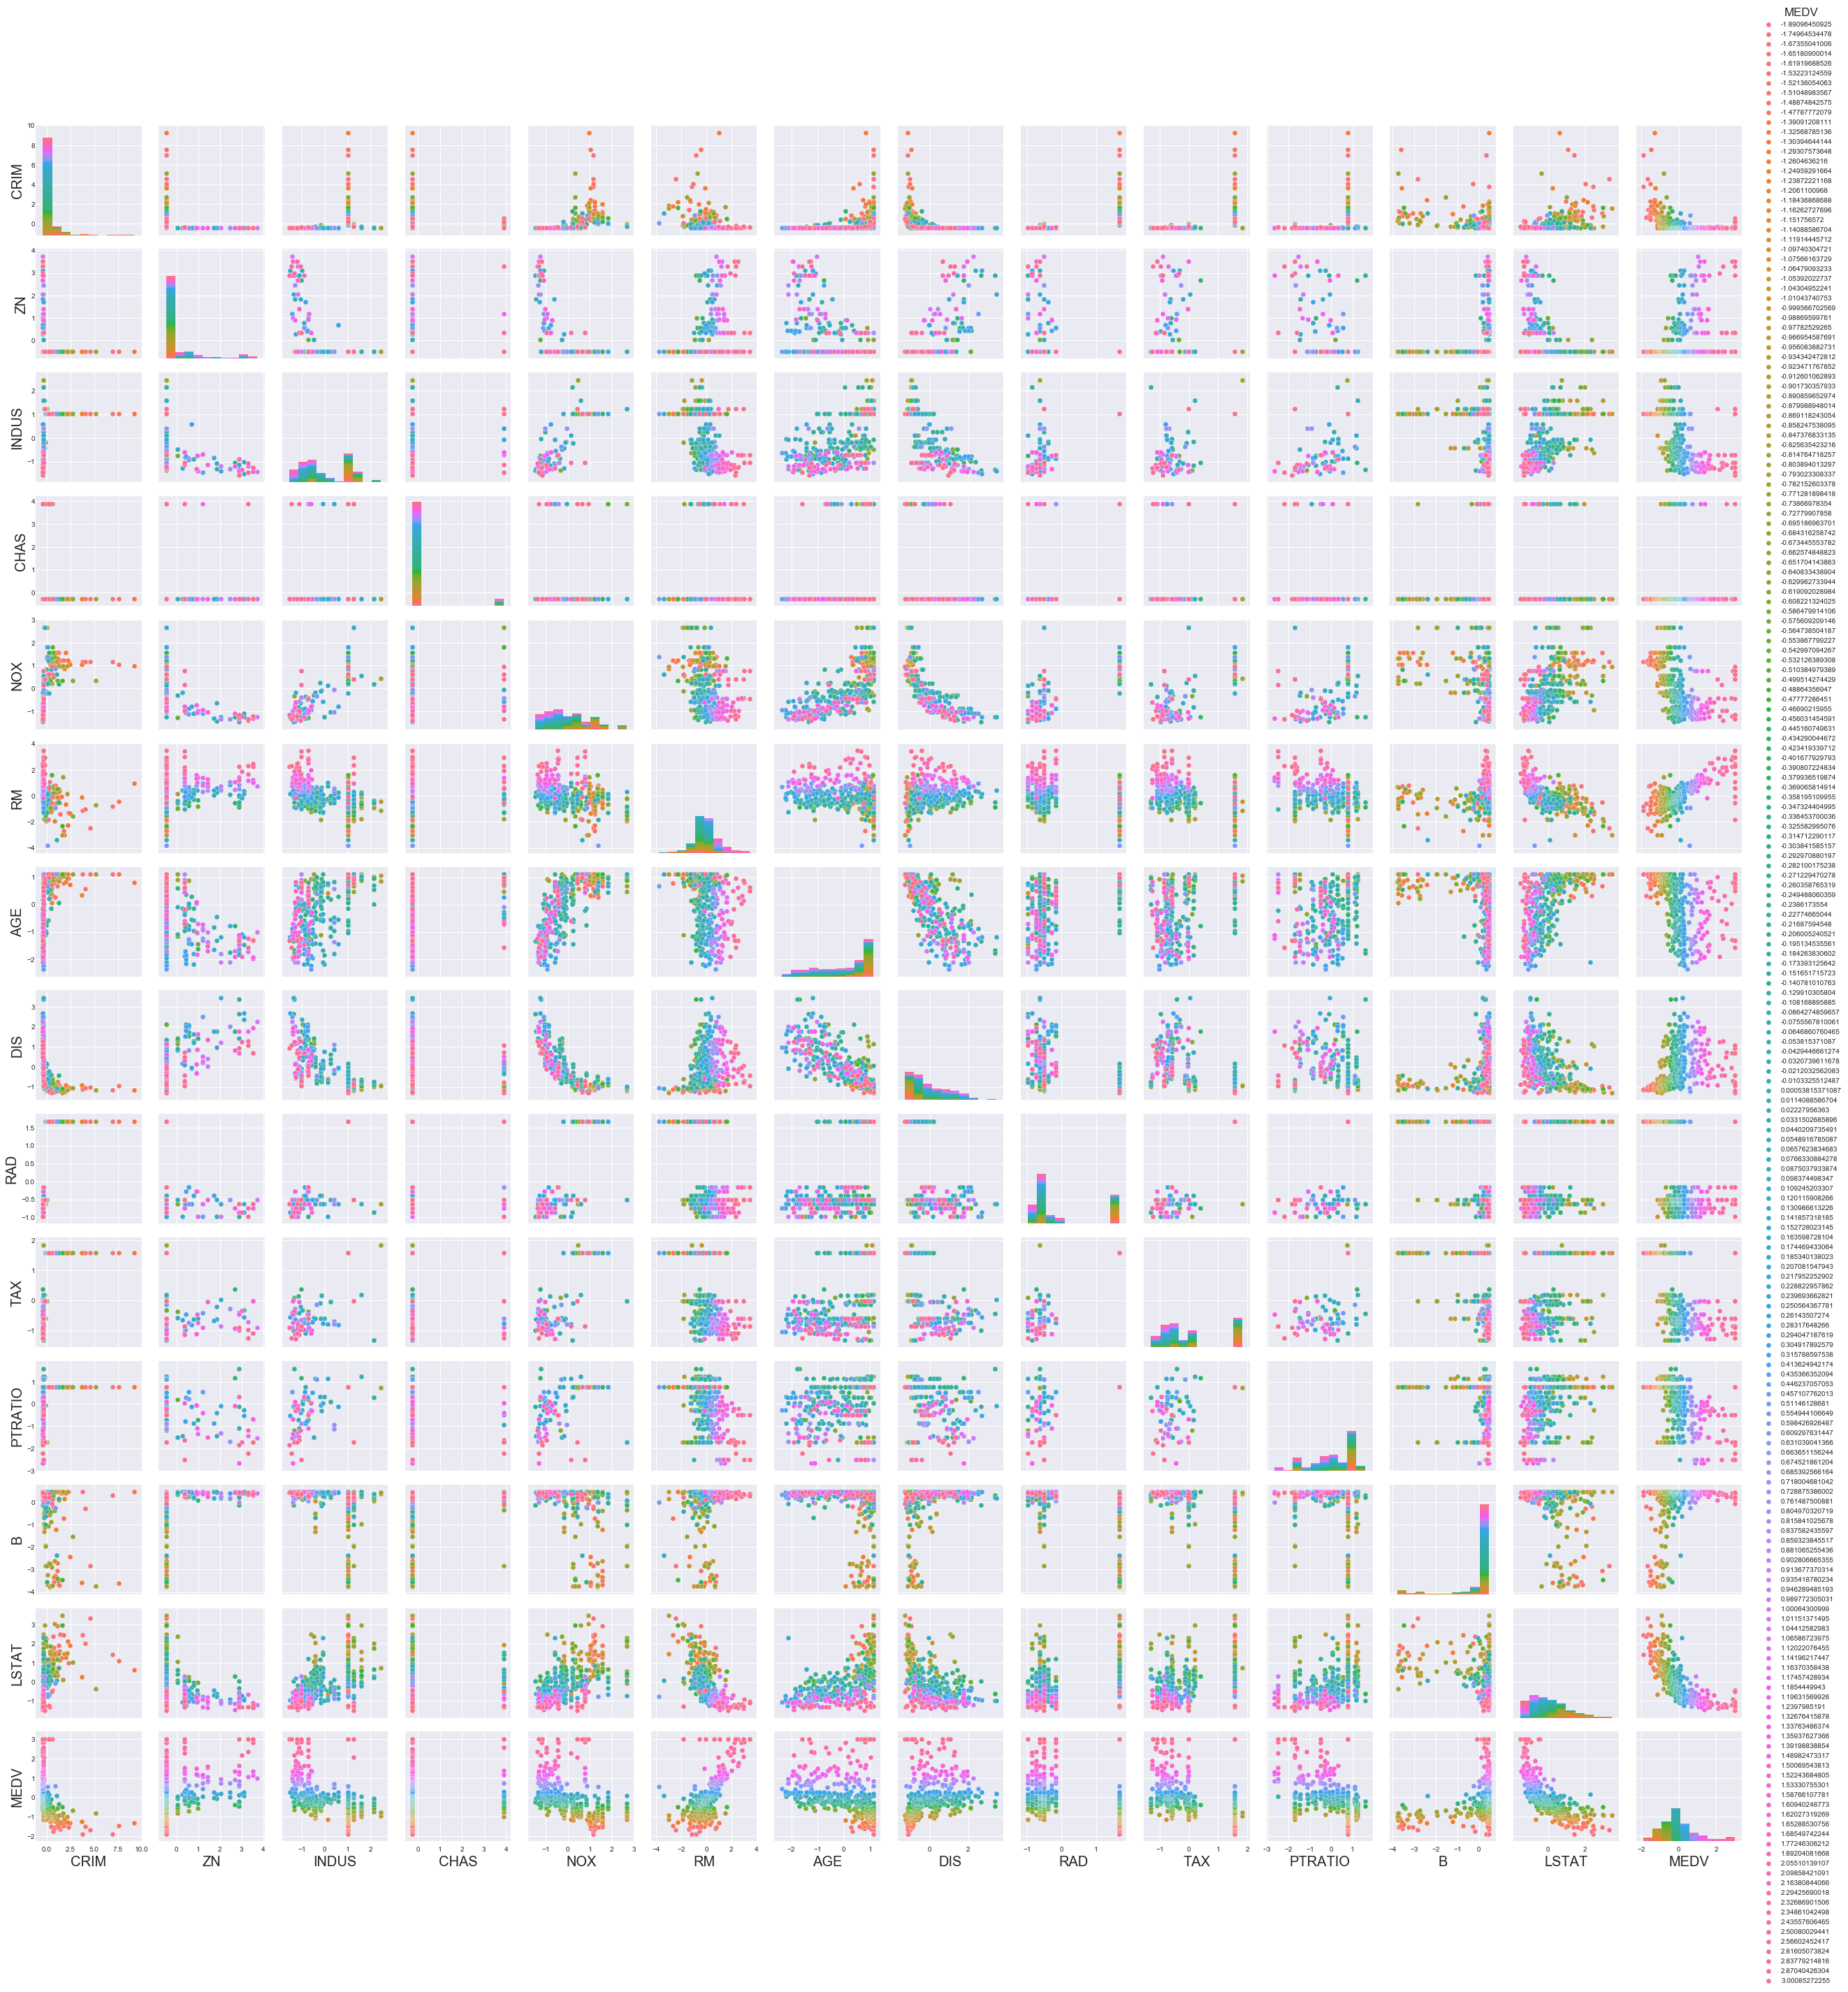

In [78]:
scaled_trainDF = pd.DataFrame(p.scale(trainDF), columns=(x_headers + y_headers))
_ = sns.pairplot(
    data = scaled_trainDF,
    vars=scaled_trainDF.columns,
    hue='MEDV')

## Why Scale?
Most predictive models work best under the assumption that the data is centered about zero, and that all features have an equal magnitude of variance. This equal variance allows the cost function of the model to weight all features equally. If some features are more important than others, they can be scaled differently so that the features variability contributes more to the cost function.


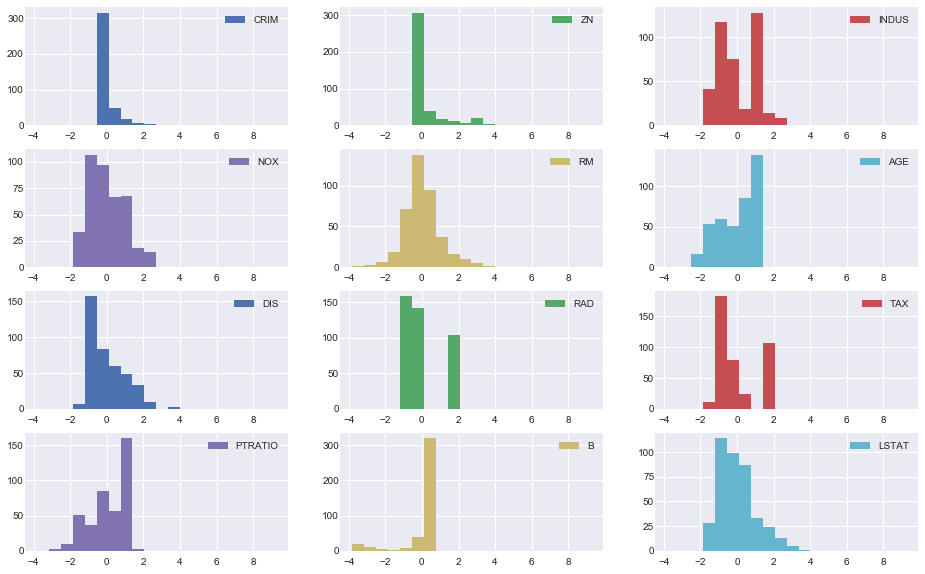

In [12]:
scaler = p.StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

fig, ax = plt.subplots(4, 3, sharey=False)

for i in range(4):
    for j in range(3):
        ax[i,j].yaxis.label.set_visible(False)

_ = pd.DataFrame(x_train_scaled, columns=x_headers).drop('CHAS',1).plot(kind='hist',bins=20,
                                              subplots=True, ax=ax)

# _ = fig.suptitle("Distribution of values by feature",fontsize=20)

In [13]:
from sklearn import model_selection as m
from keras.models import Sequential
from keras.layers import Dense

num_features = x_train.shape[1]

# Construct simple model
def base_model():
    model = Sequential()
    model.add(Dense(units=13, 
                    input_dim=num_features,
                    kernel_initializer='normal',
                    activation='relu',
                    use_bias=True))
    model.add(Dense(units=1, 
                    input_dim=num_features,
                    kernel_initializer='normal',
                    activation='linear',
                    use_bias=True))

    model.compile(loss='mean_squared_error', 
                  optimizer='sgd', 
                  metrics=['accuracy'])

    return model

    

## Notes

If the dataset is small, then there won't be enough samples to be statistically representative of the data at hand. 

To test: if different shuffling of data before splitting into test and train yield a different model performance, then there is not enough data and k-folding would be a good approach.



dict_keys(['val_acc', 'acc', 'loss', 'val_loss'])


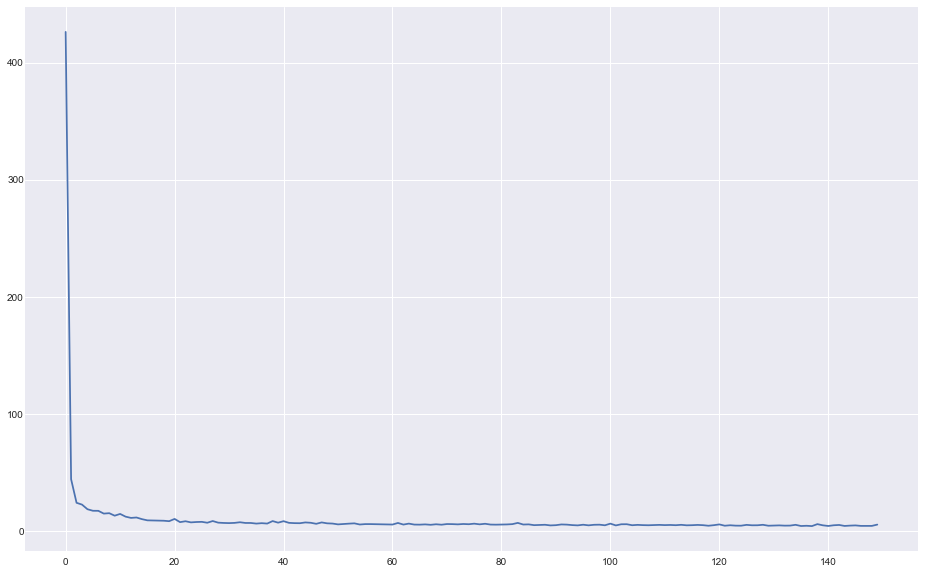

In [185]:
# join the x and y together for shuffling
y_train = y_train.reshape((y_train.shape[0],1))
data = np.hstack([x_train, y_train])

# Make random generation repeatable
seed = 7
np.random.seed(seed)

# small dataset, shuffling and folding the data
shuff_count = 3
split_count = 4

scale = p.StandardScaler()
history_set = []

for i in range(shuff_count):
    data_folds = m.KFold(n_splits=split_count, 
                         shuffle=True, 
                         random_state=seed).split(data)
    
    for train, valid in data_folds:
        
        model = base_model()
        
        # Seperate each k fold of train data into a train and validation set
        xt = scale.fit_transform(data[train,:-1])
        yt = data[train,-1:]

        # Transform validation set based on scaling on training set
        xv = scale.transform(data[valid,:-1])
        yv = data[valid,-1:]

        history = model.fit(x=xt, 
                            y=yt, 
                            validation_data=(xv, yv),
                            epochs=20, 
                            verbose=0)

        

In [ ]:
from matplotlib import gridspec

class plot_handler():
    
    def __init__(self, plot_rows, plot_cols):
        self.rows = plot_rows
        self.cols = plot_cols
        self.fig = plt.figure(facecolor='grey', figsize=(12,6))
        self.grid = gridspec.GridSpec(self.rows, self.cols)
        
        self.grid.update(left=0.05, 
                          right=0.95, 
                          wspace=0.05, 
                          top=0.8, 
                          bottom=0.4)

        self.ax = {}
    
    def __call__(self):
        plt.show
        
        
    def add_plot(self, top, bottom, left, right, name):
        self.ax[name] = self.fig.add_subplot(self.grid[top:bottom, left:right])
        self.ax[name].set_title(name)
        
    def plot_exists(name):
        if name in self.ax:
            return True
        else:
            return False
        

In [20]:
s = (slice(0,3), slice(0,8))


In [21]:
a = np.arange(100).reshape(10,10)
a[s]

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [10, 11, 12, 13, 14, 15, 16, 17],
       [20, 21, 22, 23, 24, 25, 26, 27]])